In [81]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [82]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# The following code is for random generation of colors.
# See here: https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    np.random.seed(seed=10)
    np.random.RandomState(seed=10)

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

# Load graph

In [31]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal('./datasets/ppi_mips.graphml','graphml',' ')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [32]:
g_gtool = load_graph('datasets/ppi_mips.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [33]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ppi_mips_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [34]:
g_v_prop = g_gtool.vertex_properties
groups = np.loadtxt('./datasets/ppi_mips.class', dtype = 'float')
feature_list = [groups]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_ppi_mips', ref_nodes) 
            np.save('results/info_ref_nodes_ppi_mips', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  18.0  gap  [0.91102714]  volume:  108.0  size: 9 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  28.0  gap  [0.94477965]  volume:  1861.0  size: 33 conductance:  0.4325631380977969
Reached
Number of feature 0 Feature value  34.0  gap  [0.91197756]  volume:  135.0  size: 10 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  62.0  gap  [0.95170591]  volume:  103.0  size: 8 conductance:  0.4563106796116505
Reached
Number of feature 0 Feature value  63.0  gap  [0.91102714]  volume:  108.0  size: 9 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  80.0  gap  [0.91275576]  volume:  165.0  size: 11 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  82.0  gap  [0.91787315]  volume:  1488.0  size: 32 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  87.0  gap  [0.91483327]  volume:  315.0  size: 15 conductance:  0.3333333333

## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [35]:
ref_nodes = np.load('results/ref_nodes_ppi_mips.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_ppi_mips.npy') 

## Visualize the ground truth clusters

In [121]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
    
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("vector<double>")

c_map = rand_cmap(n, type='bright', first_color_black=False, last_color_black=False, verbose=False)

for i in range(n):
    node_colours[i] = [0,0,0]

counter = 0

for i in ref_nodes:
    
    for j in i:
        node_colours[j] = c_map(int(info_ref_nodes[counter,1]))
    counter += 1

#def get_cmap(n, name='hsv'):
#    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#    RGB color; the keyword argument name must be a standard mpl colormap name.'''
#    return plt.cm.get_cmap(name, n)

#c_map = get_cmap(g_gtool.num_vertices())

#c_map = rand_cmap(n, type='bright', first_color_black=True, last_color_black=False, verbose=True)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           #vcmap = c_map
           output='ppi_mips_selected.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x136cfe390, at 0x109fd1160>

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [37]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_ppi_mips', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_ppi_mips', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_ppi_mips', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_ppi_mips', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_ppi_mips', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_ppi_mips', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_ppi_mips', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_ppi_mips', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_ppi_mips', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_ppi_mips', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_ppi_mips', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_ppi_mips', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_ppi_mips', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_ppi_mips', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_ppi_mips', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_ppi_mips', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_ppi_mips', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_ppi_mips', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_ppi_mips', cuts_acl_ALL) 
    
    np.save('results/nodes_ppi_mips', nodes)

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.25  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  806  completed:  0.5  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.75  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  374  completed:  0.0  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  357  completed:  0.0625  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  350  completed:  0.125  degree:  63.0
conductance:  0.3333333333333333 f1sco

outer: 7 number of node:  498  completed:  0.2857142857142857  degree:  20.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 7 number of node:  494  completed:  0.42857142857142855  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 7 number of node:  501  completed:  0.5714285714285714  degree:  17.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 7 number of node:  491  completed:  0.7142857142857143  degree:  27.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 7 number of node:  495  completed:  0.8571428571428571  degree:  23.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
9
outer: 8 number of node:  537  completed:  0.0  degree:  34.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  548  completed:  0.1111111111111111  degree:  23.0
conductance:  0.3

outer: 12 number of node:  921  completed:  0.42857142857142855  degree:  15.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 12 number of node:  909  completed:  0.5714285714285714  degree:  27.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 12 number of node:  920  completed:  0.7142857142857143  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 12 number of node:  908  completed:  0.8571428571428571  degree:  28.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
7
outer: 13 number of node:  866  completed:  0.0  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  873  completed:  0.14285714285714285  degree:  19.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  870  completed:  0.2857142857142857  degree:  22.0
conductan

outer: 17 number of node:  124  completed:  0.875  degree:  98.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  128  completed:  0.9  degree:  94.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  69  completed:  0.925  degree:  153.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  136  completed:  0.95  degree:  86.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  68  completed:  0.975  degree:  154.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
28
outer: 18 number of node:  4  completed:  0.0  degree:  109.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  32  completed:  0.03571428571428571  degree:  81.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
out

## Improve the results found by the spectral algorithm using MQI

In [38]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_ppi_mips.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_ppi_mips', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_ppi_mips', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.25  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  806  completed:  0.5  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.75  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  374  completed:  0.0  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  357  completed:  0.0625  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  350  completed:  0.125  degree:  63.0
conductance:  0.3333333333333333 f1sco

9
outer: 8 number of node:  537  completed:  0.0  degree:  34.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  548  completed:  0.1111111111111111  degree:  23.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  547  completed:  0.2222222222222222  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  545  completed:  0.3333333333333333  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  544  completed:  0.4444444444444444  degree:  27.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  541  completed:  0.5555555555555556  degree:  30.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  543  completed:  0.6666666666666666  degree:  28.0
conductance:  0.33

5
outer: 14 number of node:  329  completed:  0.0  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  327  completed:  0.2  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  330  completed:  0.4  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  326  completed:  0.6  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  322  completed:  0.8  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
4
outer: 15 number of node:  154  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of node:  159  completed:  0.25  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of no

conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  41  completed:  0.7857142857142857  degree:  72.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  44  completed:  0.8214285714285714  degree:  69.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  51  completed:  0.8571428571428571  degree:  62.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  55  completed:  0.8928571428571429  degree:  58.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  49  completed:  0.9285714285714286  degree:  64.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  43  completed:  0.9642857142857143  degree:  70.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
5
oute

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [39]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_ppi_mips.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0.00000000001)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_ppi_mips', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_ppi_mips', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.25  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  806  completed:  0.5  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.75  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  374  completed:  0.0  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  357  completed:  0.0625  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  350  completed:  0.125  degree:  63.0
conductance:  0.3333333333333333 f1sco

outer: 7 number of node:  494  completed:  0.42857142857142855  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 7 number of node:  501  completed:  0.5714285714285714  degree:  17.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 7 number of node:  491  completed:  0.7142857142857143  degree:  27.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 7 number of node:  495  completed:  0.8571428571428571  degree:  23.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
9
outer: 8 number of node:  537  completed:  0.0  degree:  34.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  548  completed:  0.1111111111111111  degree:  23.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  547  completed:  0.2222222222222222  degree:  24.0
conductance:  0.3

outer: 13 number of node:  866  completed:  0.0  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  873  completed:  0.14285714285714285  degree:  19.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  870  completed:  0.2857142857142857  degree:  22.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  876  completed:  0.42857142857142855  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  872  completed:  0.5714285714285714  degree:  20.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  867  completed:  0.7142857142857143  degree:  25.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  878  completed:  0.8571428571428571  degree:  14.0
conductance

outer: 18 number of node:  4  completed:  0.0  degree:  109.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  32  completed:  0.03571428571428571  degree:  81.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  1  completed:  0.07142857142857142  degree:  111.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  17  completed:  0.10714285714285714  degree:  96.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  11  completed:  0.14285714285714285  degree:  102.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  5  completed:  0.17857142857142858  degree:  108.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  8  completed:  0.21428571428571427  degree:  105.0
conductance: 

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [40]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_ppi_mips.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_ppi_mips', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_ppi_mips', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.25  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  806  completed:  0.5  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.75  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  374  completed:  0.0  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  357  completed:  0.0625  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  350  completed:  0.125  degree:  63.0
conductance:  0.3333333333333333 f1sco

9
outer: 8 number of node:  537  completed:  0.0  degree:  34.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  548  completed:  0.1111111111111111  degree:  23.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  547  completed:  0.2222222222222222  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  545  completed:  0.3333333333333333  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  544  completed:  0.4444444444444444  degree:  27.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  541  completed:  0.5555555555555556  degree:  30.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  543  completed:  0.6666666666666666  degree:  28.0
conductance:  0.33

outer: 13 number of node:  867  completed:  0.7142857142857143  degree:  25.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  878  completed:  0.8571428571428571  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
5
outer: 14 number of node:  329  completed:  0.0  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  327  completed:  0.2  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  330  completed:  0.4  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  326  completed:  0.6  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  322  completed:  0.8  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall: 

outer: 18 number of node:  30  completed:  0.2857142857142857  degree:  83.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  45  completed:  0.32142857142857145  degree:  68.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  19  completed:  0.35714285714285715  degree:  94.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  15  completed:  0.39285714285714285  degree:  98.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  36  completed:  0.42857142857142855  degree:  77.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  39  completed:  0.4642857142857143  degree:  74.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  52  completed:  0.5  degree:  61.0
conductance:  0.

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [41]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_ppi_mips.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_ppi_mips', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_ppi_mips', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.25  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  806  completed:  0.5  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.75  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  374  completed:  0.0  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  357  completed:  0.0625  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  350  completed:  0.125  degree:  63.0
conductance:  0.3333333333333333 f1sco

outer: 8 number of node:  548  completed:  0.1111111111111111  degree:  23.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  547  completed:  0.2222222222222222  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  545  completed:  0.3333333333333333  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  544  completed:  0.4444444444444444  degree:  27.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  541  completed:  0.5555555555555556  degree:  30.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  543  completed:  0.6666666666666666  degree:  28.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  539  completed:  0.7777777777777778  degree:  32.0
condu

5
outer: 14 number of node:  329  completed:  0.0  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  327  completed:  0.2  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  330  completed:  0.4  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  326  completed:  0.6  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  322  completed:  0.8  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
4
outer: 15 number of node:  154  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of node:  159  completed:  0.25  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of no

outer: 18 number of node:  8  completed:  0.21428571428571427  degree:  105.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  40  completed:  0.25  degree:  73.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  30  completed:  0.2857142857142857  degree:  83.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  45  completed:  0.32142857142857145  degree:  68.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  19  completed:  0.35714285714285715  degree:  94.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  15  completed:  0.39285714285714285  degree:  98.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  36  completed:  0.42857142857142855  degree:  77.0
conductance:  

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [42]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_ppi_mips.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_ppi_mips', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_ppi_mips', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.25  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  806  completed:  0.5  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.75  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  374  completed:  0.0  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  357  completed:  0.0625  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  350  completed:  0.125  degree:  63.0
conductance:  0.3333333333333333 f1sco

outer: 8 number of node:  547  completed:  0.2222222222222222  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  545  completed:  0.3333333333333333  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  544  completed:  0.4444444444444444  degree:  27.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  541  completed:  0.5555555555555556  degree:  30.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  543  completed:  0.6666666666666666  degree:  28.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  539  completed:  0.7777777777777778  degree:  32.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  540  completed:  0.8888888888888888  degree:  31.0
condu

outer: 14 number of node:  329  completed:  0.0  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  327  completed:  0.2  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  330  completed:  0.4  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  326  completed:  0.6  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 14 number of node:  322  completed:  0.8  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
4
outer: 15 number of node:  154  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of node:  159  completed:  0.25  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of node

outer: 18 number of node:  45  completed:  0.32142857142857145  degree:  68.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  19  completed:  0.35714285714285715  degree:  94.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  15  completed:  0.39285714285714285  degree:  98.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  36  completed:  0.42857142857142855  degree:  77.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  39  completed:  0.4642857142857143  degree:  74.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  52  completed:  0.5  degree:  61.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  10  completed:  0.5357142857142857  degree:  103.0
conductance:  0

## Generate scatter plot

In [43]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_ppi_mips.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_ppi_mips.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_ppi_mips.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_ppi_mips.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_ppi_mips.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_ppi_mips.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_ppi_mips.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_ppi_mips.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_ppi_mips.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

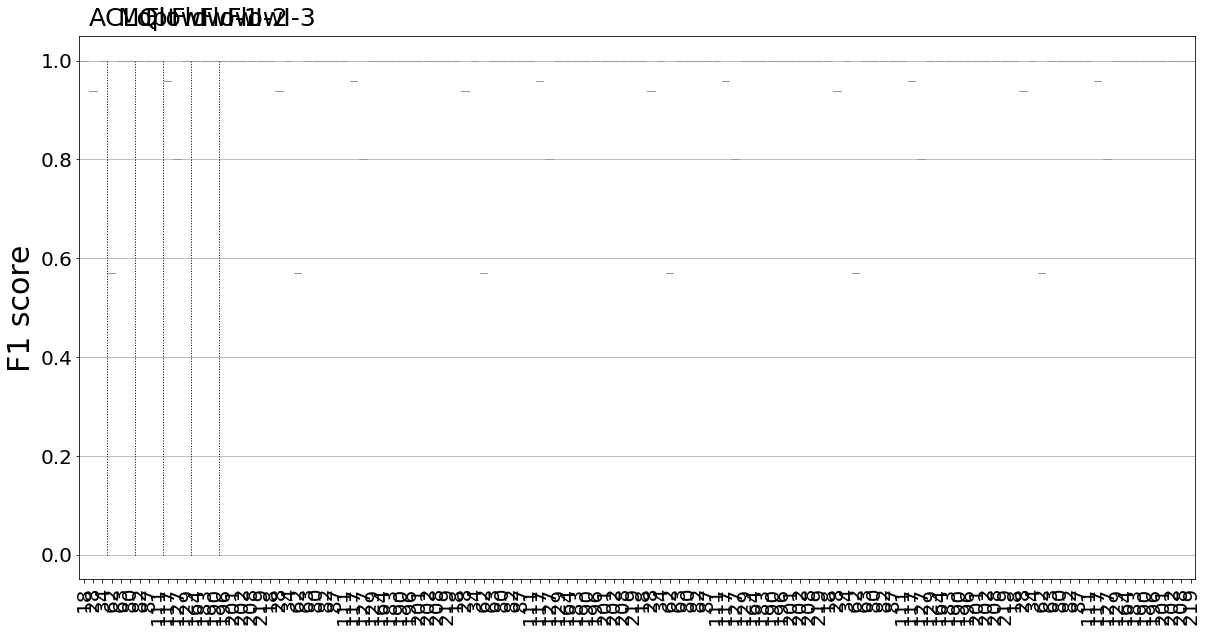

In [44]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_f1.png')

plt.show()

## Generate scatter plot for precision

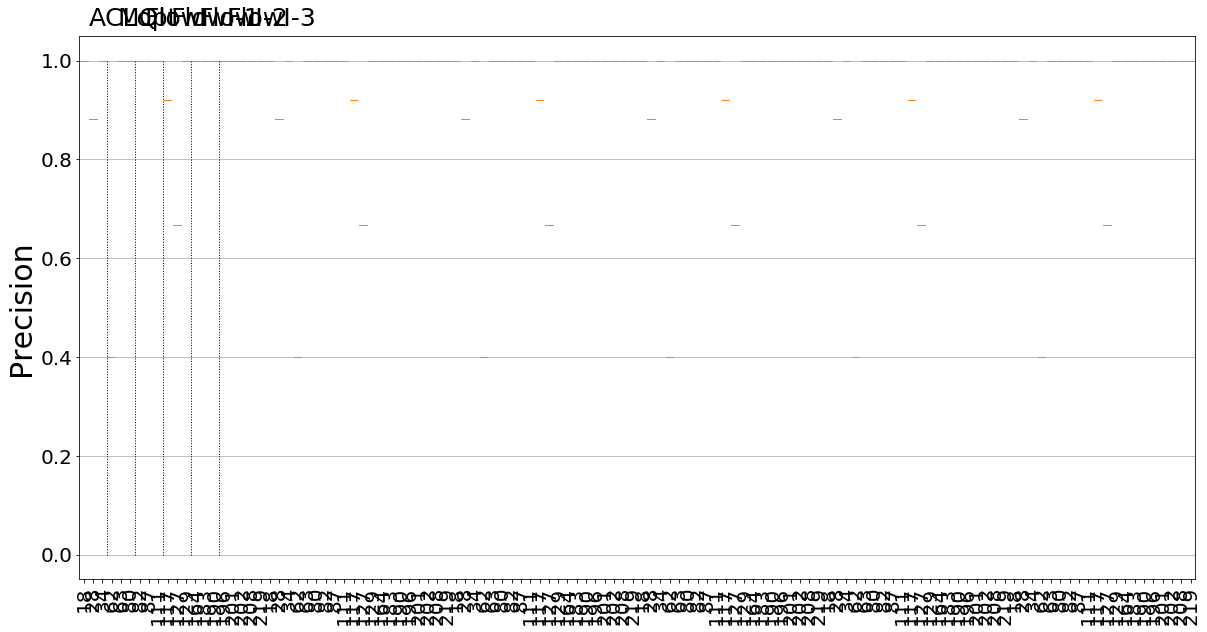

In [45]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_precision.png')

plt.show()

## Generate scatter plot for recall

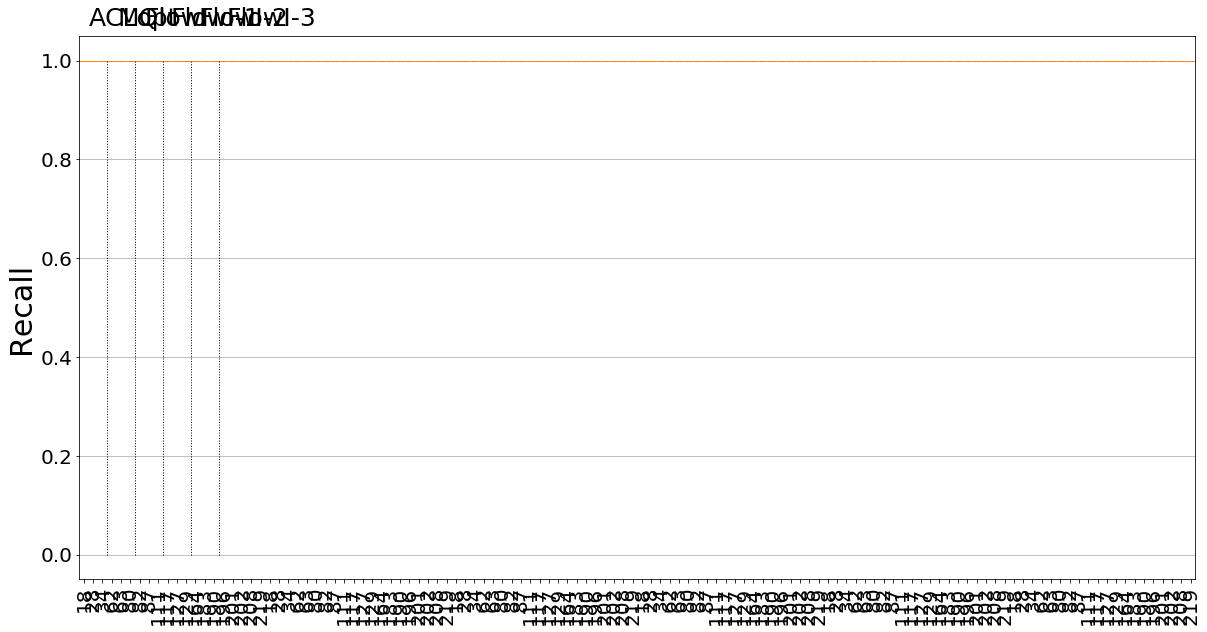

In [46]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_recall.png')

plt.show()

In [47]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 18.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 28.0 Precision 0.8824087245139877 Recall 1.0 F1 0.9375314861460956
Feature: 34.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 62.0 Precision 0.3992248062015504 Recall 1.0 F1 0.5706371191135734
Feature: 63.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 80.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 82.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 87.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 111.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 117.0 Precision 0.9206349206349206 Recall 1.0 F1 0.9586776859504132
Feature: 127.0 Precision 0.6668161434977579 Recall 1.0 F1 0.8001076136669356
Feature: 129.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 164.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 183.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 190.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 196.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 201.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 202.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 208.0 Precisio